### Import libraries

In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd
from wordcloud import WordCloud
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from dataclasses import dataclass, field
from typing import List, Dict
import jupyter_black
from imblearn.over_sampling import SMOTE

In [3]:
jupyter_black.load()

### Data loading and exploratory analysis

In [4]:
train = pd.read_json("../../datasets/recipe/train.json")

In [5]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [6]:
print(f"Shape: {train.shape}")
print(f"Columns: {train.columns}")

Shape: (39774, 3)
Columns: Index(['id', 'cuisine', 'ingredients'], dtype='object')


In [7]:
# Check for null values

print(f"No. of null values:\n{train.isnull().sum()}")

No. of null values:
id             0
cuisine        0
ingredients    0
dtype: int64


In [8]:
# Unique output classes

print(f"Unique output classes: {train['cuisine'].unique()}")

Unique output classes: ['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [9]:
# Input

print(train["ingredients"][0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']


Checking for imbalance

In [10]:
# No. of entries for each output class

print("No. of entries for each class- ")
print(train["cuisine"].value_counts())

No. of entries for each class- 
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64


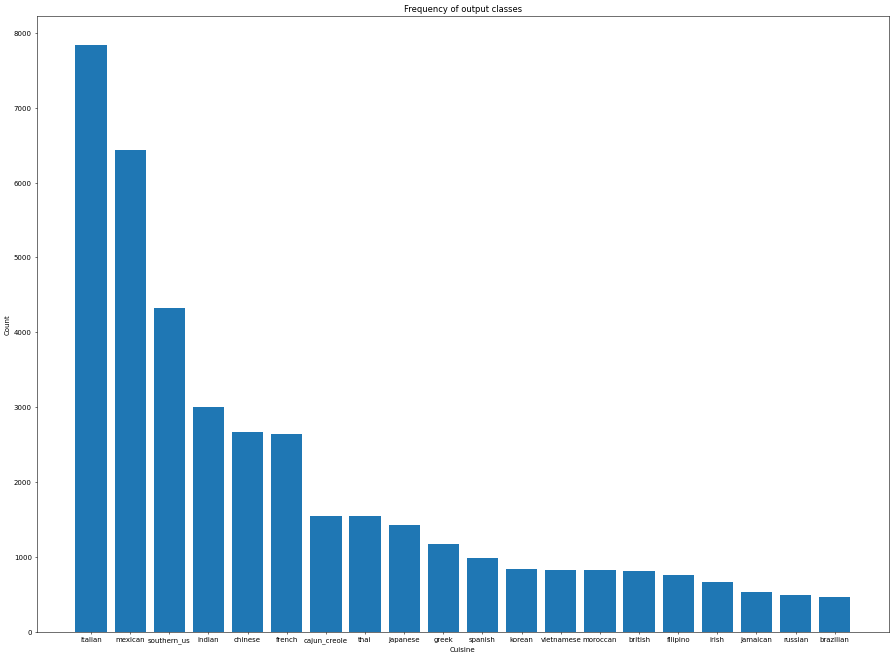

In [11]:
plt.subplots(figsize=(22, 16), dpi=50)
plt.title("Frequency of output classes")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.bar(train["cuisine"].value_counts().index, train["cuisine"].value_counts().values)
plt.show()

The dataset is **imbalanced**

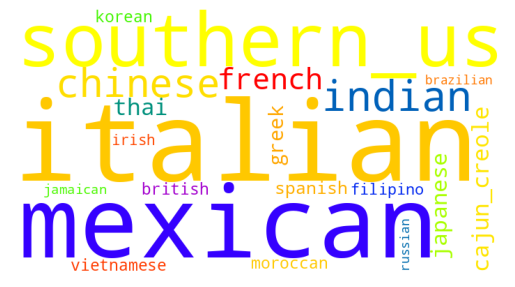

In [12]:
wordcloud_cuisine = WordCloud(
    background_color="white", width=712, height=384, colormap="prism"
).generate(" ".join(train["cuisine"].values))

plt.imshow(wordcloud_cuisine)
plt.axis("off")
plt.show()

In [13]:
ingredient_count = {}

for ingredients_list in train["ingredients"].values:
    for ingredient in ingredients_list:
        if ingredient not in ingredient_count:
            ingredient_count[ingredient] = 1
        else:
            ingredient_count[ingredient] += 1

In [14]:
ingredient_count

{'romaine lettuce': 270,
 'black olives': 229,
 'grape tomatoes': 228,
 'garlic': 7380,
 'pepper': 4438,
 'purple onion': 1896,
 'seasoning': 137,
 'garbanzo beans': 148,
 'feta cheese crumbles': 358,
 'plain flour': 154,
 'ground pepper': 385,
 'salt': 18049,
 'tomatoes': 3058,
 'ground black pepper': 4785,
 'thyme': 361,
 'eggs': 3388,
 'green tomatoes': 108,
 'yellow corn meal': 341,
 'milk': 2263,
 'vegetable oil': 4385,
 'mayonaise': 781,
 'cooking oil': 483,
 'green chilies': 768,
 'grilled chicken breasts': 5,
 'garlic powder': 1442,
 'yellow onion': 1184,
 'soy sauce': 3296,
 'butter': 4848,
 'chicken livers': 65,
 'water': 7457,
 'wheat': 26,
 'black pepper': 2627,
 'shallots': 1477,
 'cornflour': 103,
 'cayenne pepper': 1523,
 'onions': 7972,
 'garlic paste': 282,
 'lemon juice': 1395,
 'chili powder': 2036,
 'passata': 24,
 'oil': 1970,
 'ground cumin': 2747,
 'boneless chicken skinless thigh': 343,
 'garam masala': 925,
 'double cream': 40,
 'natural yogurt': 18,
 'bay leaf

In [15]:
print(f"No. of unique ingredients: {len(ingredient_count.keys())}")

No. of unique ingredients: 6714


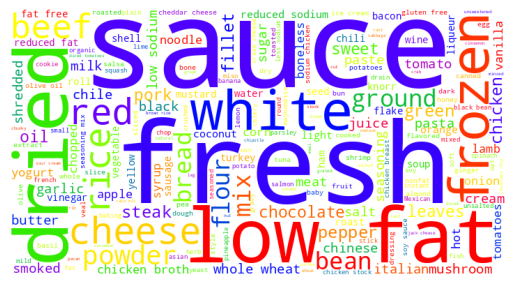

In [16]:
wordcloud = WordCloud(
    background_color="white", width=712, height=384, colormap="prism"
).generate(" ".join(ingredient_count.keys()))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Data preprocessing

In [17]:
# Transform input classes to numpy array

mb = MultiLabelBinarizer()
train_x = mb.fit_transform(train["ingredients"])

In [18]:
mb.classes_

array(['(    oz.) tomato sauce', '(   oz.) tomato paste',
       '(10 oz.) frozen chopped spinach', ..., 'ziti', 'zucchini',
       'zucchini blossoms'], dtype=object)

In [19]:
# Oversample minority classes using SMOTE technique

smt = SMOTE()
train_x, train_y = smt.fit_resample(train_x, train["cuisine"])

In [20]:
# Transform target variables to tensor

lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
train_y = torch.FloatTensor(train_y)
train_y.shape

torch.Size([156760, 20])

In [21]:
lb.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype='<U12')

In [22]:
# Convert input to tensor

train_x = torch.FloatTensor(train_x)
train_x.shape

torch.Size([156760, 6714])

In [23]:
train_x.shape, train_y.shape

(torch.Size([156760, 6714]), torch.Size([156760, 20]))

### Logistic Regression Model

In [24]:
@dataclass
class LogisticMultiClass:
    """
    Class that represents the Logistic Regression Model

    Attributes
    ----------
    X: ``torch.Tensor``
        Input data to the model
    Y: ``torch.Tensor``
        Output data used for supervised learning
    epoch: ``int`` ( default = 10 )
        Number of times the training samples are to be read / No. of iterations of model
    learning_rate: ``str`` ( default = 0.1 )
        Learning rate used to affect the rate of gradient descent
    print_cost: ``str`` ( default = False )
        Flag that determines if cost is to be printed while training the model
    draw_cost: ``str`` ( default = False )
        Flag that determines if a plot of cost function vs epoch is to be drawn
    params: ``str`` ( default = {} )
        Parameters of the model
    grads: ``str`` ( default = {} )
        Gradient of every parameter
    costs: ``str`` ( default = [] )
        List containing cost after each epoch
    """

    X: torch.Tensor
    Y: torch.Tensor
    epoch: int = 100
    learning_rate: int = 0.1
    print_cost: bool = False
    draw_cost: bool = False
    params: Dict = field(default_factory=dict)
    grads: Dict = field(default_factory=dict)
    costs: List = field(default_factory=list)

    def initialize_params(self) -> Dict[str, torch.Tensor]:
        """
        Initialize parameters for the model

        Returns
        -------
        parameters: ``Dict[str, torch.Tensor]``
        """

        w = torch.rand((6714, 20)) * 0.01
        b = torch.zeros((1, 1))

        self.params["w"] = w
        self.params["b"] = b

        return self.params

    def compute_cost(self, a: torch.Tensor) -> torch.Tensor:
        """
        Compute the cost of the model

        Parameters
        ----------
        a: ``torch.Tensor``
            Activation output of the final layer

        Returns
        -------
        cost: ``torch.Tensor``
            Cost of the model after one forward pass
        """

        # cost = - torch.mean(((self.Y * torch.log(a).transpose(0, 1)) + ((1 - self.Y) * torch.log(1 - a).transpose(0, 1))))
        cost = -torch.mean(self.Y * torch.log(a).transpose(0, 1))
        return cost

    def forward_propagation(self, X: torch.Tensor) -> torch.Tensor:
        """
        Perform one forward pass

        Parameters
        ----------
        X: ``torch.Tensor``
            Tensor containing the input features

        Returns
        -------
        z: ``torch.Tensor``
        """

        w = self.params["w"]
        b = self.params["b"]
        z: torch.Tensor = torch.mm(w.transpose(0, 1), X.transpose(0, 1)) + b

        return z

    def backpropagation(self, a: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Perform one backward pass

        Parameters
        ----------
        a: ``torch.Tensor``
            Tensor containing the activations of the final layer

        Returns
        -------
        gradients: ``Dict[str, torch.Tensor]``
            Gradients required to modify parameters of the model
        """
        dw = (
            torch.mm(self.X.transpose(0, 1), (a.transpose(0, 1) - self.Y))
            / self.X.shape[0]
        )

        db = torch.mean(a - self.Y.transpose(0, 1))

        self.grads["dw"] = dw
        self.grads["db"] = db

        return self.grads

    def optimize(self) -> Dict[str, torch.Tensor]:
        """
        Optimize the model by updating its parameters

        Returns
        -------
        parameters: ``Dict[str, torch.Tensor``
        """

        w = self.params["w"]
        b = self.params["b"]
        dw = self.grads["dw"]
        db = self.grads["db"]

        w -= self.learning_rate * dw
        b -= self.learning_rate * db

        self.params["w"] = w
        self.params["b"] = b

        return self.params

    def softmax(self, z):
        return torch.exp(z - torch.max(z)) / torch.sum(torch.exp(z - torch.max(z)))

    def train(self, continued: bool = False) -> Dict[str, torch.Tensor]:
        """
        Perform training on the model

        Parameters
        ----------
        continued: ``bool``
            Flag to determine if the model is being trained for the first time or if its being continued

        Returns
        -------
        parameters: ``Dict[str, torch.Tensor]``
            The final parameters of the model that can be used to make predictions
        """

        if not continued:
            self.params = self.initialize_params()
        for i in range(self.epoch):
            z = self.forward_propagation(self.X)
            a = self.softmax(z)
            cost = self.compute_cost(a)
            self.costs.append(cost)

            if self.print_cost:
                print(f"Cost after epoch {i+1}: {cost}")

            self.grads = self.backpropagation(a)
            self.params = self.optimize()

        if self.draw_cost:
            self.draw()

        return self.params

    def draw(self):
        """
        Method to plot the variation of cost of model over different epochs
        """

        plt.title("Learning rate = " + str(self.learning_rate))
        plt.xlabel("No. of epochs")
        plt.ylabel("Cost Function")
        plt.plot(range(0, self.epoch), self.costs)
        plt.show()

    def predict(self, X_test: torch.Tensor) -> torch.Tensor:
        """
        Perform predictions for given input data

        Parameters
        ----------
        X_test: ``torch.Tensor``
            Tensor containing the input data for which predictions are to be obtained

        Returns
        -------
        predictions: ``torch.Tensor``
            Tensor that holds the predictions for given input data
        """

        z = self.forward_propagation(X_test)
        a = torch.sigmoid(z)

        a[a < 0.5] = 0
        a[a >= 0.5] = 1

        a = a.transpose(0, 1)

        return torch.squeeze(a)

    def score(self, X_test: torch.Tensor, Y_test: torch.Tensor) -> float:
        """
        Perform one backward pass

        Parameters
        ----------
        X_test: ``torch.Tensor``
            Tensor containing the input data

        Y_test: ``torch.Tensor]``
            Tensor containing output data for corresponding input data

        Returns
        -------
        scores: ``Dict[str, float]``
            Tensor containing output data for corresponding input data
        """

        predictions = self.predict(X_test)
        scores = {}

        TP, TN, FP, FN = torch.zeros(1, 20)
        for actual, prediction in zip(Y_test, predictions):
            for i in range(20):  # No. of output classes = 20
                # True Positive
                if actual[i] == 1 and prediction[i] == 1:
                    TP[i] += 1
                # True Negative
                elif actual[i] == 0 and prediction[i] == 0:
                    TN[i] += 1
                # False positive
                elif actual[i] == 0 and prediction[i] == 1:
                    FP[i] += 1
                # False negative
                elif actual[i] == 1 and prediction[i] == 0:
                    FN[i] += 1

        accuracy = torch.div((TP + TN), (TP + TN + FP + FN))
        precision = torch.div(TP, (TP + FP))
        recall = torch.div(TP, (TP + FN))
        specificity = torch.div(TN, (TN + FP))
        f1_score = 2 * torch.div((precision * recall), (precision + recall))

        scores["accuracy"] = accuracy
        scores["precision"] = precision
        scores["recall"] = recall
        scores["specificity"] = specificity
        scores["f1_score"] = f1_score

        return scores

### Train the model

Cost after epoch 1: 0.7479022145271301
Cost after epoch 2: 0.7475995421409607
Cost after epoch 3: 0.7473000288009644
Cost after epoch 4: 0.7470037937164307
Cost after epoch 5: 0.7467108964920044
Cost after epoch 6: 0.746421217918396
Cost after epoch 7: 0.746134877204895
Cost after epoch 8: 0.7458519339561462
Cost after epoch 9: 0.7455722689628601
Cost after epoch 10: 0.745296061038971


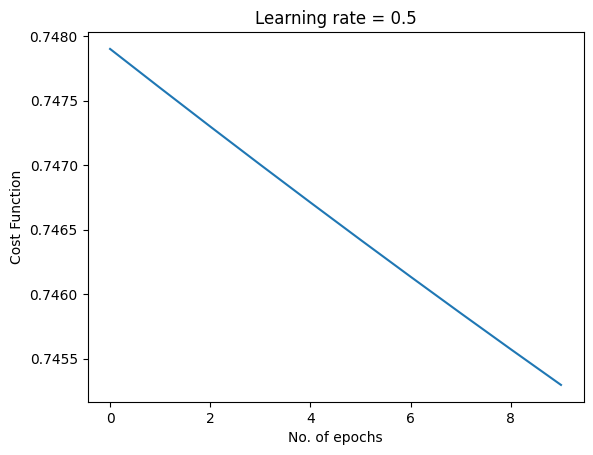

In [25]:
cls = LogisticMultiClass(
    train_x, train_y, epoch=10, learning_rate=0.5, print_cost=True, draw_cost=True
)
params = cls.train()

### Testing the model

In [26]:
test = pd.read_json("../../datasets/recipe/test.json")

In [27]:
test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [28]:
test_x = mb.transform(test["ingredients"])
test_x = torch.FloatTensor(test_x)
test_x.shape

/home/vignesh-pt6720/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['2% reduced fat chocolate milk', '33% less sodium smoked ham', '50% less sodium black beans', 'Asian herb', 'Best Foods Mayonnaise Dressing with Extra Virgin Olive Oil', 'Boursin Cheese with Garlic and Herbs', 'Bramley apples', 'CURRY GUY Smoked Tandoori Masala', 'Chobani Yogurt', 'Crisco Canola Oil', 'Daisy Brand Light Sour Cream', 'Del Monte Diced Tomatoes', 'Domaine de Canton Ginger Liqueur', 'Dreamfields Lasagna', 'Dubliner cheese', 'Duncan Hines Classic White Cake Mix', 'Foster Farms chicken drumsticks', 'Franks Wings Sauce', "French's Spicy Brown Mustard", 'Goya Corn Oil', 'Goya Seasoning', 'Green Giant™ Steamers™ Niblets® frozen corn', 'Green Giant™ frozen chopped spinach', 'Grey Poupon Dijon Mustard', "Hellmann's Mayonnaise with a hint of Wasabi", 'Hershey bars', 'Holland House White Cooking Wine', 'Honey Bunches of Oats Cereal', 'Johnsonville® Italian A

torch.Size([9944, 6714])

In [29]:
predictions = cls.predict(test_x)
print(predictions)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
